# Web Scraping for Indeed.com & Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being to able extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

### Aims and Objectives
The outcome of this project will be to create a classification model that can be used to determine the expected salary of a Data Scientist based on their location and Job title within the USA. A number of models will be looked at with increasing complexity the models will be judged on their accuracy score. Intitially I will look at prediciting whether the salary can be predicted as  'high' or 'low'. After this I will split the salary brackets further.

In [2]:
import requests
import bs4
from bs4 import BeautifulSoup
import urllib2
import re
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

In [12]:
#This function extracts relevant job details from adverts placed on the US indeed jobs website, 
#it takes in a URL and searches for the relevant information within the HTML

def information_gather(url):
    Companies=[]
    Locations=[]
    Titles=[]
    Salaries=[]
    Descriptions=[]
    
    page=urllib2.urlopen(url).read()
    soup = BeautifulSoup(page)
    
    #Company
    #This section scrapes information pertaining to the company name.
    Company_Data=soup.findAll('span',{'class':'company'})
    for x in Company_Data:
        try:
            Companies.append(x.contents[1].a.string)
        except:
            Companies.append(x.contents[1].string)
            
    #Location
    #This section scrapes information pertaining to the job location    
    Location_Data=soup.findAll('span',{'class':'location'})
    
    for x in Location_Data:
        Locations.append(x.string)
        
        
    Title_Data=soup.findAll('h2',{'class':'jobtitle'})
    
    #Job Title
    #This section scrapes information pertaining to the job title  
    for x in Title_Data:
        Titles.append(x.a.get('title'))
        
    #Salary data
    
    Salary_Data=soup.findAll('td',{'class':'snip'})
    #This section scrapes information pertaining to the job salary if it is availble, if not it passes.  
    for x in Salary_Data:
        try: 
            Salaries.append(x.nobr.string)
        except:
            Salaries.append(np.nan)
    
    #Job Summary Data
    #This section scrapes information pertaining to the job summary information if it is availble, if not it passes.  
    Summary_Data=soup.findAll('span',{'class':'summary'})
    for x in Summary_Data:
        try:
            st=x.text.replace('\n',' ')
            Descriptions.append(st.strip())
        except:
            Descriptions.append(np.nan)
    #All of the Lists are combined into a dataframe which is outputted.            
    Out_df=pd.DataFrame({'Company_Name':Companies,
                         'Location':Locations,
                         'Job_Title':Titles,
                         'Salary':Salaries,
                         'Descriptions':Descriptions})
    return Out_df

In [13]:
#This function creates URLs based on Location(s) and the number of jobs to search for. 
#The function calls on the function above to extract the information, if there is no information in the URL,
#the function passes to the next Location. The function returns a single DataFrame of all the the results.
def indeed_extract(Locations,Number):
    counter=0
    for y in Locations:
        for x in range(0,Number,100):
            try:
                url_string=''.join(['http://www.indeed.com/jobs?q=data+scientist&l=',y,'&limit=100&start=',str(x)])
                if counter==0:
                    Output=information_gather(url_string)
                    counter+=1
                else:
                    New_df=information_gather(url_string)
                    Output=Output.append(New_df,ignore_index=True)
            except:
                pass
    return Output

In [14]:
#List of locations in which to search for job adverts
Locations_List=['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
    'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
    'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami']

In [15]:
#Use the function created above with the locations above, atmpeting to find up to 1500 jobs in each of the locations.
df=indeed_extract(Locations_List,1500)
print df.shape
df.head()

(18248, 5)


,Company_Name,Descriptions,Job_Title,Location,Salary
0,W2O Group,Data Scientists should have a background in th...,Data Scientist,"New York, NY",NaN
1,"Discovery Communications, Inc.","The Analyst, Data Science & Digital Analytics ...",Data Scientist,"New York, NY",NaN
2,Credit Suisse,"This role demands niche skills in PNL, Machine...",Data Scientist # 081836,None,NaN
3,Scienaptic Systems Inc,"As our representative in front of client, you ...",Data Scientist,"New York, NY","$100,000 a year"
4,Capital One,At least 3 years’ experience with machine lear...,Data Scientist,"New York, NY",NaN


In [16]:
#Drops all duplicate job adverts
df=df.drop_duplicates()
print df.shape
df.head()

(4585, 5)


,Company_Name,Descriptions,Job_Title,Location,Salary
0,W2O Group,Data Scientists should have a background in th...,Data Scientist,"New York, NY",NaN
1,"Discovery Communications, Inc.","The Analyst, Data Science & Digital Analytics ...",Data Scientist,"New York, NY",NaN
2,Credit Suisse,"This role demands niche skills in PNL, Machine...",Data Scientist # 081836,None,NaN
3,Scienaptic Systems Inc,"As our representative in front of client, you ...",Data Scientist,"New York, NY","$100,000 a year"
4,Capital One,At least 3 years’ experience with machine lear...,Data Scientist,"New York, NY",NaN


In [18]:
#Saves the table with no duplicates as a .csv file.
df.to_csv('Job_Data.csv',encoding='utf-8')

In [3]:
#Drops all job adverts that have missing information.
df=pd.read_csv('Job_Data.csv')
Salary_df=df.dropna()
print Salary_df.shape
Salary_df.head()

(285, 6)


,Unnamed: 0,Company_Name,Descriptions,Job_Title,Location,Salary
3,3,\n Scienaptic Systems Inc,"As our representative in front of client, you ...",Data Scientist,"New York, NY","$100,000 a year"
30,30,\n Centers for Disease Control and Prev...,Whether we are protecting the American people ...,Health Scientist,"New York, NY","$88,305 - $146,570 a year"
32,32,\n POLICE DEPARTMENT,"Extensive knowledge of applied statistics, ana...",Data Analytics Research Scientist,"New York, NY","$70,286 - $88,213 a year"
95,95,\n DBFS Ltd,Applying Machine Learning Algorithms and Libra...,Quantitative Research Analyst,"New York, NY","$60,000 - $120,000 a year"
151,151,\n Wade & Wendy,"Software Engineering, Python, Data Visualizati...",Wade & Wendy_Data Scientist/Engineer,"New York, NY","$80,000 - $120,000 a year"


## Initial Data Appraisal
Initially a maximum of 800 job positings were scrapped from the website for each location, however once it became evident that nearly 3 in 4 of the adverts  and only 1 in 15 postings containing salary information,this was increased to 1500. A total of over 18000 job postings were scrapped, this number was reduced to just 285, once duplicates and entries with missing information were removed. The remainign data is as extpected from desciptive information - a little bit noisey. Below is a list of notes about the noise in each of the main variables and the assumptions that will be used to clean this noise in order to categorise the data.

#### Job Title
There is a wide range of the Job Titles from Analysits to Lab Researchers some of these relate to Data Science, however a lot do not. Some job titles were also for more senior positions, with an expected increase in salary to go along with the increased responsibility.
- Key strings will be searched for pertaining to data science and analyist job titles - The obvious being 'Data Scientist' and 'Analyst', however others will be looked at including 'Big Data' and 'Machine Learning'.
- Key strings designated a more senior role will also be searched for including terms such as 'manager' 'lead' and 'senior'.
- The data will be filtered by four Job Titles, any jobs that do not fit into these titles will be dropped. The titles are as follows: Analyst, Senior Analyst, Data Scientist, Senior Data Scientist.

#### Location
Locations tend to vary quite largly throughout most the states, meaning that if the locations are used in their current state there will be an extremely large amount of unique categories resulting in a reduction of the accuracy of the model. Soem of the location descriptions include zip code information, whilst others do not.
- Locations will be categorised by state, with states with very few positings grouped into an 'other' category. A seperate category will also be created for San Fransisco as higher salaries will be expected within this region.

#### Salary
The Salary information provided is in a variety of timeframes, ranging from $ per hour to annual salaries. Also salaries are sometimes provided in ranges rather then single values.
- Salary inforamtion will converted to annual rates, based on the assumptions of a 40 hour working week and a 52 week working year. This may result in extremely large values for hourly and day rates, however this will be sense checked to ensure that they are in line with annual salaries, and if necessary a weighting reduction will be applied.
- Any salaries provided in ranges will be averaged between the two values.



In [4]:
#This function searchs for strings in the salary section denoting the payment period, it then returns these strings.
def salary_time(entry):
    Pay_Period=['a year','a month','a week','an hour','a day']
    for x in Pay_Period:
        if x in str(entry):
            return x   

In [5]:
#The function above is applied to the salary column and resulting output is entered into a new column entitled Rate
TimeFrame=Salary_df['Salary'].map(lambda x: salary_time(x))
#Converts the salary column into a string, and then removes all non numeric values apart from the - and .
Rate=Salary_df['Salary'].astype('str')
Rate=Rate.map(lambda x: ''.join([c for c in x if c in '1234567890-.']))
#Attaches the newly created dataframes to the working dataframe
Salary_df=Salary_df.join(pd.DataFrame({'Rate':Rate,'Timeframe':TimeFrame}))
Salary_df.head()

,Unnamed: 0,Company_Name,Descriptions,Job_Title,Location,Salary,Rate,Timeframe
3,3,\n Scienaptic Systems Inc,"As our representative in front of client, you ...",Data Scientist,"New York, NY","$100,000 a year",100000,a year
30,30,\n Centers for Disease Control and Prev...,Whether we are protecting the American people ...,Health Scientist,"New York, NY","$88,305 - $146,570 a year",88305-146570,a year
32,32,\n POLICE DEPARTMENT,"Extensive knowledge of applied statistics, ana...",Data Analytics Research Scientist,"New York, NY","$70,286 - $88,213 a year",70286-88213,a year
95,95,\n DBFS Ltd,Applying Machine Learning Algorithms and Libra...,Quantitative Research Analyst,"New York, NY","$60,000 - $120,000 a year",60000-120000,a year
151,151,\n Wade & Wendy,"Software Engineering, Python, Data Visualizati...",Wade & Wendy_Data Scientist/Engineer,"New York, NY","$80,000 - $120,000 a year",80000-120000,a year


In [6]:
#Check to see the frequency of different payment periods. 
Salary_df['Timeframe'].value_counts()

a year     208
a month     46
an hour     30
a week       1
Name: Timeframe, dtype: int64

In [7]:
#This function finds the current payment rate and calculates the annual salary based on the timeframe provided.
#This is assuming a working day of 40 hours a week and 52 working weeks a year.
def SalaryCalc(Rate,Timeframe):
    Inc_dict={'a year':1,'a month':12,'a week':52,'an hour':2080,'a day':220}
    if '-' in Rate:
        Inc_list=Rate.split('-')
        Inc=np.mean([float(Inc_list[0]),float(Inc_list[1])])
    else:
        Inc=float(Rate)
    return Inc*Inc_dict[Timeframe]

In [8]:
#The function above is applied to the dataframe resulting in a new column with the calcualted annual income.
Salary_df['Annual_Inc']=Salary_df.apply(lambda x: SalaryCalc(x['Rate'],x['Timeframe']),axis=1)
Salary_df.sort_values(by='Annual_Inc',ascending=False).head()

,Unnamed: 0,Company_Name,Descriptions,Job_Title,Location,Salary,Rate,Timeframe,Annual_Inc
1873,5438,\n Z2 DataLabs,At least 2 years of solid industry experience ...,Data Science Instructor (Local Candidates ONLY),"Bellevue, WA",$150 an hour,150,an hour,312000.0
3118,8647,\n Averity,We are looking for a Quantitative Analyst with...,Quantitative Analyst (Big Data Focus) at $10+ ...,"Philadelphia, PA","$200,000 - $300,000 a year",200000-300000,a year,250000.0
303,403,\n Harnham,Chief Data Scientist - Consulting. Chief Data ...,Chief Data Scientist - Consulting,"New York, NY","$220,000 a year",220000,a year,220000.0
327,427,\n Averity,Enabling our Data Scientists to create product...,Executive Director of Data Engineering,"New York, NY","$200,000 - $230,000 a year",200000-230000,a year,215000.0
1120,2973,\n Averity,Enabling our Data Scientists to create product...,Executive Director of Data Engineering,"San Francisco, CA","$180,000 - $230,000 a year",180000-230000,a year,205000.0


In [9]:
#Find the most common job titles, in order to get an idea of what strings to search for when 
#creating Job Title categories
Salary_df['Job_Title'].value_counts()

Data Scientist                                                            12
Research Analyst                                                           5
Senior Data Scientist                                                      3
Machine Learning Engineer                                                  2
Health Scientist                                                           2
MEDICAL LABORATORY SCIENTIST LEAD                                          2
Research Scientist                                                         2
Executive Director of Data Engineering                                     2
Data Engineer                                                              2
Sponsored Research Financial Analyst                                       2
CHIEF RESEARCH ANALYST, BEHAVIORAL SCIENCES                                2
RESEARCH ANALYST I, BEHAVIORAL SCIENCES/SPANISH                            2
Business Process Consultant (Oracle OPM SME) (2) - GA                      2

In [10]:
#Remove all non numeric charactors from the location columns, as some of the locations contained zip codes.
Salary_df['Location']=Salary_df['Location'].map(lambda x: ''.join([c for c in x if c not in '1234567890-.']))
#Remove any additional spaces from the end and beginning of the location strings.
Salary_df['Location']=Salary_df['Location'].map(lambda x: x.strip())

In [11]:
#This function searches for key strings in order to determine what the job role is, if one of these strings 
#is found the function then returns one of 4 job title categories.
def Role_Check(x):
    Analyst=['analyst','data analysis']
    Data_Sci=['data scientist','research scientist','machine learning',
              'analytics','big data','data science','python scientist']
    out=''
    x=x.lower()
    for c in Data_Sci:
        if c in x:
            out='Data Scientist'
    if out=='':
        for c in Analyst:
            if c in x:
                out='Analyst'
    if out=='':
        return np.nan
    else:
        return out
    
#This function checks to see if there is a string relating to a senior level in the job description,
# if so the function returns the string senior 
def Level_Check(x):
    Senior_Level=['Sr','Lead','Senior','Snr','Chief','Principal','Director','Manager','Instructor']
    x=x.lower()
    for y in Senior_Level:
        b=y.lower()
        if b in x:
            return 'Senior'
    return np.nan

#This function checks to see if there is a senior level assigned, and if so concatenates 
#it with the Role, ortherwise it just returns the role.
def Create_Title(x,y):
    if y is np.nan:
        return x
    else:
        return ' '.join([y,x])

In [12]:
#Using the function above, a new column titled Role is created assinging either Data Scientist 
#or Analyist roles based ont he strings within the original job title.
Salary_df['Role']=Salary_df['Job_Title'].apply(lambda x: Role_Check(x))

#Using the function above a new column titled Level is created assigning whether the role is senior or not.
Salary_df['Level']=Salary_df['Job_Title'].apply(lambda x: Level_Check(x))
Salary_df.head()

,Unnamed: 0,Company_Name,Descriptions,Job_Title,Location,Salary,Rate,Timeframe,Annual_Inc,Role,Level
3,3,\n Scienaptic Systems Inc,"As our representative in front of client, you ...",Data Scientist,"New York, NY","$100,000 a year",100000,a year,100000.0,Data Scientist,NaN
30,30,\n Centers for Disease Control and Prev...,Whether we are protecting the American people ...,Health Scientist,"New York, NY","$88,305 - $146,570 a year",88305-146570,a year,117437.5,NaN,NaN
32,32,\n POLICE DEPARTMENT,"Extensive knowledge of applied statistics, ana...",Data Analytics Research Scientist,"New York, NY","$70,286 - $88,213 a year",70286-88213,a year,79249.5,Data Scientist,NaN
95,95,\n DBFS Ltd,Applying Machine Learning Algorithms and Libra...,Quantitative Research Analyst,"New York, NY","$60,000 - $120,000 a year",60000-120000,a year,90000.0,Analyst,NaN
151,151,\n Wade & Wendy,"Software Engineering, Python, Data Visualizati...",Wade & Wendy_Data Scientist/Engineer,"New York, NY","$80,000 - $120,000 a year",80000-120000,a year,100000.0,Data Scientist,NaN


In [13]:
#Removes any rows where there is no Job title assigned.
Salary_df=Salary_df[~Salary_df['Role'].isnull()]
print Salary_df.shape
Salary_df.head(2)

(158, 11)


,Unnamed: 0,Company_Name,Descriptions,Job_Title,Location,Salary,Rate,Timeframe,Annual_Inc,Role,Level
3,3,\n Scienaptic Systems Inc,"As our representative in front of client, you ...",Data Scientist,"New York, NY","$100,000 a year",100000,a year,100000.0,Data Scientist,NaN
32,32,\n POLICE DEPARTMENT,"Extensive knowledge of applied statistics, ana...",Data Analytics Research Scientist,"New York, NY","$70,286 - $88,213 a year",70286-88213,a year,79249.5,Data Scientist,NaN


In [14]:
#Creates a new column called 'Title_Cat' that contains job titles as generated 
#by the the function Create_title which joins the Role and the Level if applicable.
Salary_df['Title_Cat']=Salary_df.apply(lambda x: Create_Title(x['Role'],x['Level']),axis=1)

#Creates a new coloum called 'Income_Cat', this columns contains catergoical values 
#of whether the salary is low or high based on a percentile spit
Salary_df['Income_Cat']=pd.qcut(Salary_df['Annual_Inc'],2)
Salary_df['Income_Cat_Bin']=pd.qcut(Salary_df['Annual_Inc'],2,labels=[0,1])
#Creates an output Dataframe with only the cleaned data in it.
Output_Table=Salary_df[['Title_Cat','Location','Descriptions','Annual_Inc','Income_Cat','Income_Cat_Bin']]
Output_Table.head()

,Title_Cat,Location,Descriptions,Annual_Inc,Income_Cat,Income_Cat_Bin
3,Data Scientist,"New York, NY","As our representative in front of client, you ...",100000.0,"(89165.5, 312000]",1
32,Data Scientist,"New York, NY","Extensive knowledge of applied statistics, ana...",79249.5,"[24960, 89165.5]",0
95,Analyst,"New York, NY",Applying Machine Learning Algorithms and Libra...,90000.0,"(89165.5, 312000]",1
151,Data Scientist,"New York, NY","Software Engineering, Python, Data Visualizati...",100000.0,"(89165.5, 312000]",1
181,Analyst,"New York, NY",Several hires over the past two years have bee...,120000.0,"(89165.5, 312000]",1


In [15]:
#Find the frequency of each of the states in the output data in order to group them if necessary.
Output_Table['Location'].map(lambda x: x[-2:]).value_counts()

NY    38
CA    34
TX    24
GA    12
WA    11
FL     9
IL     8
AZ     7
PA     7
CO     6
OR     1
NJ     1
Name: Location, dtype: int64

In [16]:
#Creates a function that extracts the state from the location, the function also 
#groups some of the less common states into a category called 'other' and creates a 
#seperate category for san-franscco where salaries are assumed to be higher then the 
#rest of the state of california.
def State_Sort(Location):
    if 'San Francisco' in Location:
        x= 'SFCA'
    else:
        x = ''.join(list(Location.strip())[-2:])
    if x in ['OR','CO','NJ','PA','AZ']:
        x='OTHER'
    return x

In [17]:
#Apply the state sort function to the Location column in the Output Table and put the 
#resulting values in a new columne titled 'Location_Short'
Output_Table['Location_Short']=Output_Table['Location'].map(lambda x: State_Sort(x))

/Users/annacrawford/anaconda/envs/Zaincorp/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [18]:
#Check to see the distribution of the Jobs by Job title
Output_Table['Title_Cat'].value_counts()

Analyst                  62
Data Scientist           43
Senior Data Scientist    32
Senior Analyst           21
Name: Title_Cat, dtype: int64

In [19]:
#Check to see the distribution of the Jobs by state
Output_Table['Location_Short'].value_counts()

NY       38
TX       24
CA       23
OTHER    22
GA       12
SFCA     11
WA       11
FL        9
IL        8
Name: Location_Short, dtype: int64

In [20]:
#Create a pivot table, where Job title frequencies are grouped by Location 
#in order to create a corresponding heat map.
Heat_Table=pd.pivot_table(Output_Table,
                          index='Title_Cat',
                          columns='Location_Short',
                          aggfunc='count')

In [214]:
print Output_Table['Annual_Inc'].describe()

count       158.000000
mean     101581.922152
std       47859.286790
min       24960.000000
25%       65244.250000
50%       89165.500000
75%      130250.000000
max      312000.000000
Name: Annual_Inc, dtype: float64


We can see some summary figures for the salary information above, the median is lower then the mean, which means we should expect to see a right skew when plotting the distirbution. This is un-suprising as Salarys tend to follow the Paerto distribution. The maximum salary is based off an hourly rate so this is perhaps a bit to high, but we will model the results as they are and see how much of an outlier this is.

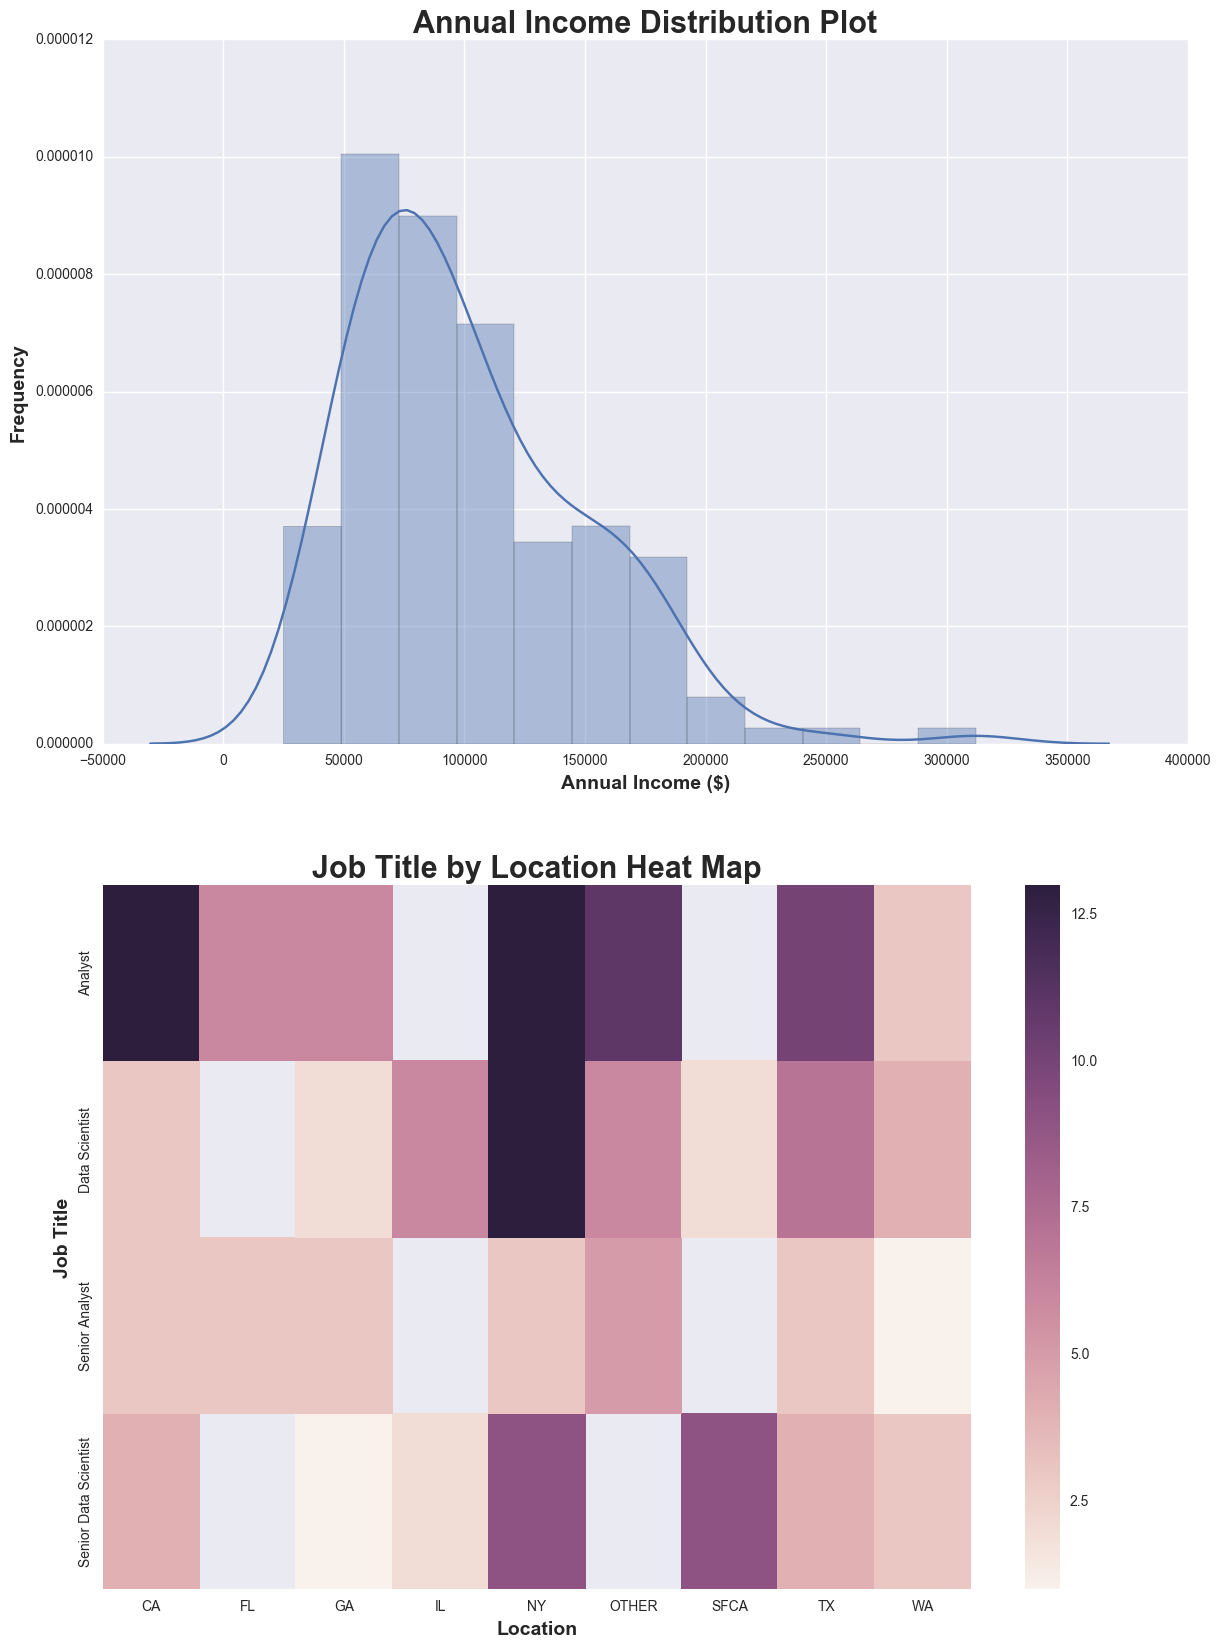

In [21]:
#Font Dictionaries
Title = {'weight':'bold',
        'size':22}
Label = {'weight':'bold',
        'size':14}

#Create Figure with 2 subplots
fig=plt.figure(figsize=(14,20))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)

#Create a distribution plot of all of the salaries.
sns.distplot(Output_Table['Annual_Inc'],
             ax=ax1)

ax1.set_xlabel('Annual Income ($)',fontdict=Label)
ax1.set_ylabel('Frequency',fontdict=Label)
ax1.set_title('Annual Income Distribution Plot',fontdict=Title)

#Create a heat map of job role by location.
sns.heatmap(Heat_Table['Location'],
            ax=ax2)

ax2.set_xlabel('Location',fontdict=Label)
ax2.set_ylabel('Job Title',fontdict=Label)
ax2.set_title('Job Title by Location Heat Map',fontdict=Title)

Unsuprisingly the Income distribution is skewed to the right as expected. From the heat map we can see that even using the search term 'Data Scientist', the majority of jobs in most locations returned where Analyst roles, this is with the exception of San Francisco and New York. This is probably due to the bigger tech industries in these locations. In those states groouped as other, no Senior Data Scientist roles were found.

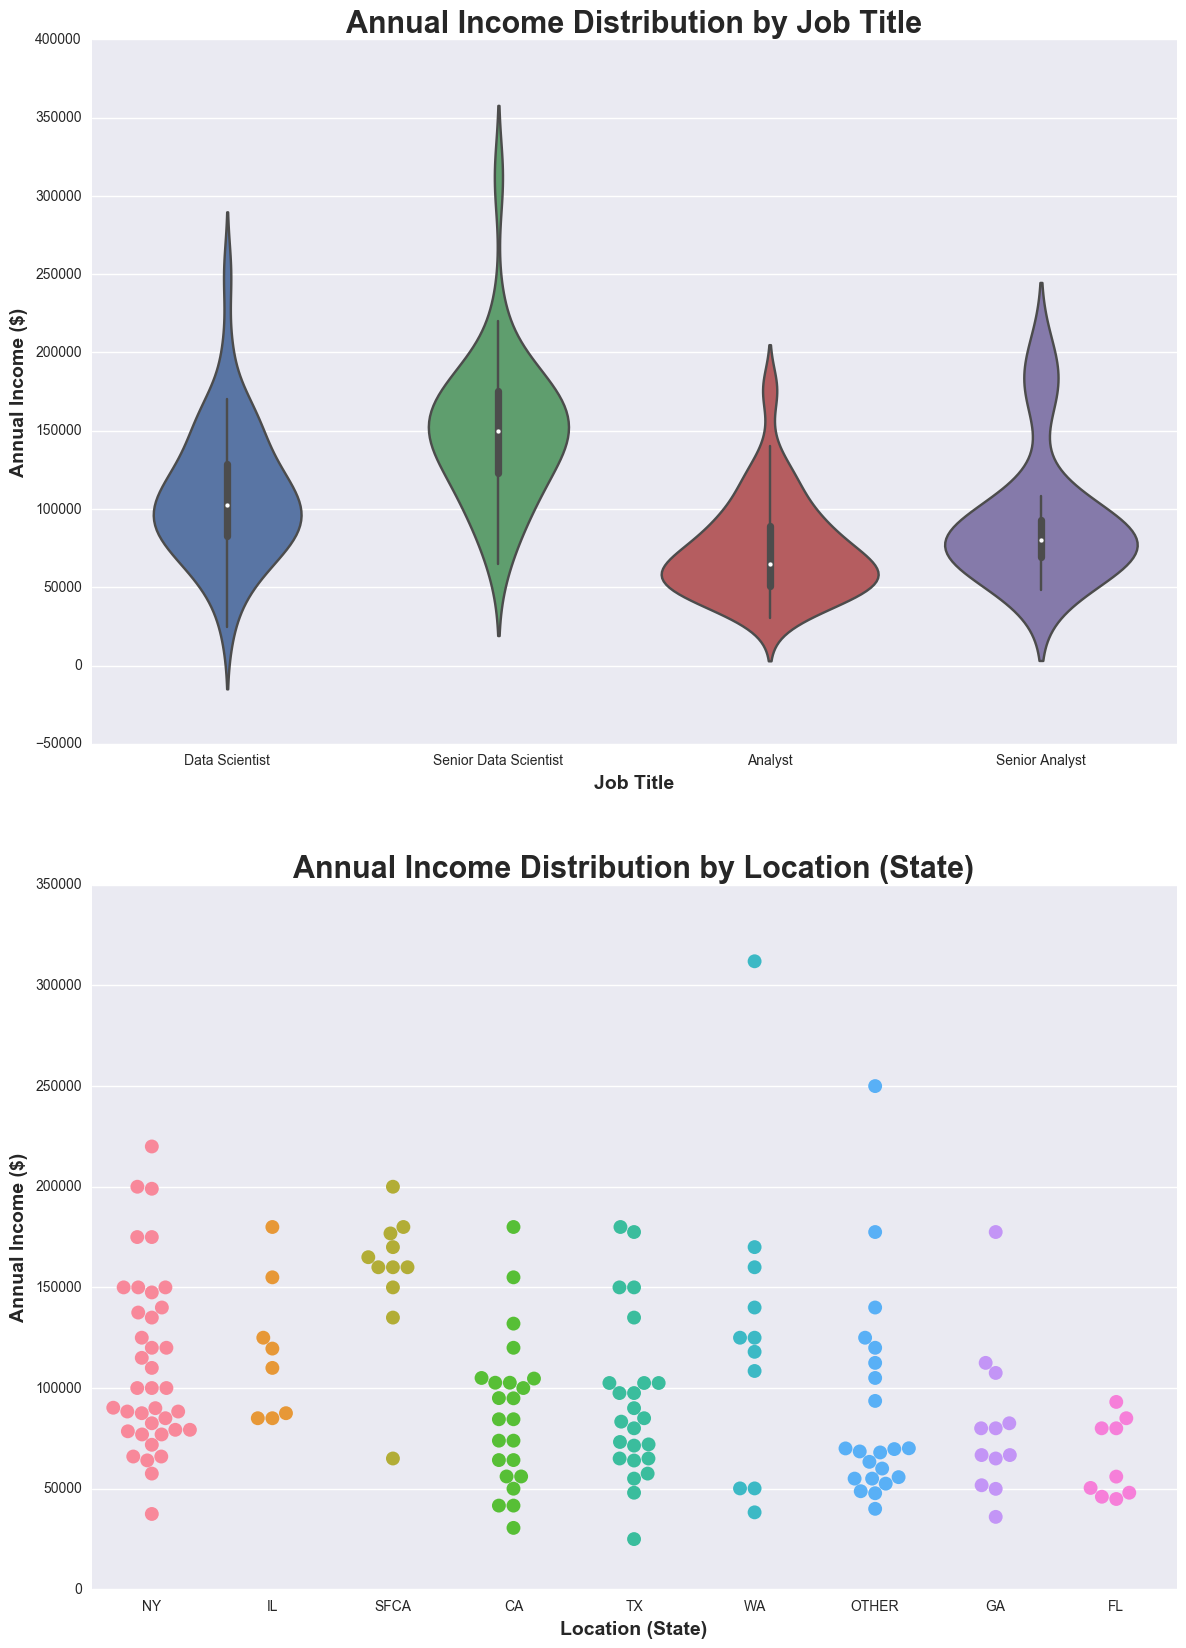

In [22]:
#Create Figure with 2 subplots
fig=plt.figure(figsize=(14,20))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)

#Create a violin plot of the 4 Job titles showing their income distribution
sns.violinplot(x=Output_Table['Title_Cat'],
               y=Output_Table['Annual_Inc'],
               ax=ax1,
               order=['Data Scientist','Senior Data Scientist','Analyst','Senior Analyst'])

ax1.set_xlabel('Job Title',fontdict=Label)
ax1.set_ylabel('Annual Income ($)',fontdict=Label)
ax1.set_title('Annual Income Distribution by Job Title',fontdict=Title)

#Create a swarm plot of Income by location
sns.swarmplot(x=Output_Table['Location_Short'],
              y=Output_Table['Annual_Inc'],
              ax=ax2,
              size=10)

ax2.set_xlabel('Location (State)',fontdict=Label)
ax2.set_ylabel('Annual Income ($)',fontdict=Label)
ax2.set_title('Annual Income Distribution by Location (State)',fontdict=Title)

From the Salary distributions by job role, we can see that the functions used to seperate lead and junior roles have been effective, in that the salary distrutions for the senior roles are higher as would be expected. Data Science roles also tend to have a higher salary mean and median then Analyst roles with senior Data Scientist roles having the highester incomes.

The Swarm plot above also clearly shows where the tech industry is strongest - New York and San Francisco, with a large groups of more well paid jobs. We have two slight outliers, in WA and OTHER, one is a yearly salary whilst the job in WA is an instructor role, paid hourly. Due to the nature of salaries, I do not feel these are significant enough to require any modification. 

The results will now be modelled using a classification logisitc regression. I had some issues using statsmodel so have used sklearns model instead.

## Predicting salaries using Logistic Regression

#### Variables - Location
THe first model will just use the Location as the driving varible with the target as categorical income level of above or below ~$90000. This model will serve as our base, and variables will be added to it. I will use a test train split of about 30%-70% in order to provide a large enough test size so that there will not be a large descrepency between the training and test results.

In [215]:
#Set types to category for modelling.
Output_Table['Location'].astype('category')
Output_Table['Title_Cat'].astype('category')
Output_Table.head(2)

,Title_Cat,Location,Descriptions,Annual_Inc,Income_Cat,Income_Cat_Bin,Location_Short
3,Data Scientist,"New York, NY","As our representative in front of client, you ...",100000.0,"(89165.5, 312000]",1,NY
32,Data Scientist,"New York, NY","Extensive knowledge of applied statistics, ana...",79249.5,"[24960, 89165.5]",0,NY


In [52]:
import matplotlib.patheffects as path_effects
#Creating a function use to plot confusion matrecies
def plot_confusion_matrix(cm, title='Confusion matrix', labels=['Positive','Negative'], cmap=plt.cm.Blues):  
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)   
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels,rotation=45)
    plt.yticks(tick_marks, labels)      
    plt.title(title)
    plt.ylabel('True Salary')
    plt.xlabel('Predicted Salary')
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=40).set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                                       path_effects.Normal()])

In [112]:
#Creating dummies for the location categories
X=Output_Table['Location_Short']
X=pd.get_dummies(X)
y=Output_Table['Income_Cat_Bin']

#### Thought experiment: What is the baseline accuracy for this model?

In [113]:
#Createing test and train splits based on a test size of 30%
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=3)

#### Create a Logistic Regression model to predict High/Low salary using statsmodel. Start by ONLY using the location as a feature. Display the coefficients and write a short summary of what they mean.

In [114]:
#Creating and fiting a logisitc regression model using the base hyper perameters.
from sklearn import linear_model
from sklearn.metrics import confusion_matrix,classification_report
Logit=linear_model.LogisticRegression()
model=Logit.fit(X_train,y_train)
y_pred=model.predict(X_test)
print model.score(X_train,y_train)
print model.score(X_test,y_test)
cm = confusion_matrix(y_test, y_pred)

0.627272727273
0.625


In [115]:
cls_rep = classification_report(y_test, y_pred)
print cls_rep

             precision    recall  f1-score   support

          0       0.57      0.77      0.65        22
          1       0.72      0.50      0.59        26

avg / total       0.65      0.62      0.62        48



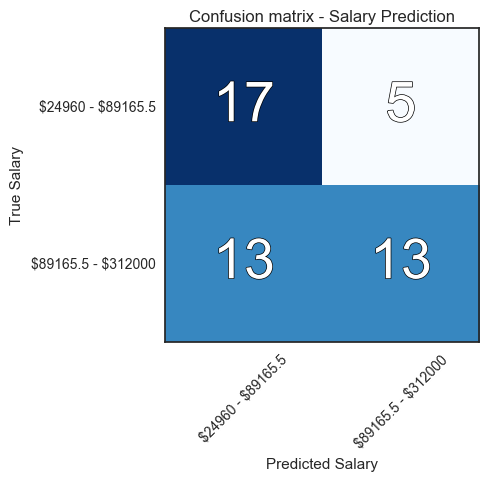

In [116]:
plot_confusion_matrix(cm, 
                      title='Confusion matrix - Salary Prediction', 
                      labels=['\$24960 - \$89165.5','\$89165.5 - \$312000'], 
                      cmap=plt.cm.Blues)

The initial model has an accuracy of just over 62%, this is better then the base of 50%, so the model has had an impact, however I should be able to impove on this with the addition of further varibles. For prediciting the higher salaries, the model has scored more highly for precision rather then recall, meaning for those jobs that had higher salaries it was sometimes predicted as a lower salary, however those roles with lower salaries the prdictions were more accurate.

For the next model I will add Job Title categories.

In [144]:
#Create dummy varibles for the Location and Job Title.
X=Output_Table[['Location_Short','Title_Cat']]
X=pd.get_dummies(X,columns=['Location_Short','Title_Cat'])
y=Output_Table['Income_Cat_Bin']

In [145]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=3)

In [146]:
Logit=linear_model.LogisticRegression()
model=Logit.fit(X_train,y_train)
y_pred=model.predict(X_test)
print model.score(X_train,y_train)
print model.score(X_test,y_test)
cm = confusion_matrix(y_test, y_pred)

0.745454545455
0.75


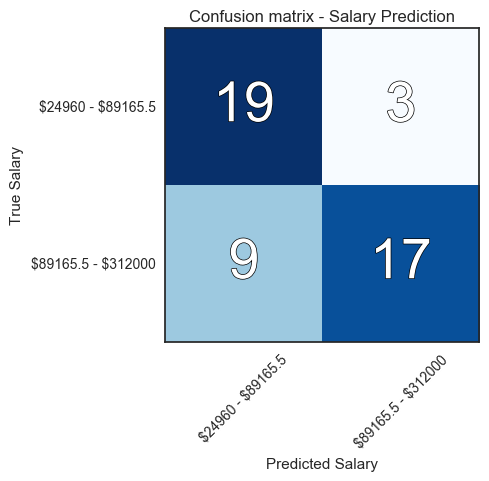

In [147]:
plot_confusion_matrix(cm, 
                      title='Confusion matrix - Salary Prediction', 
                      labels=['\$24960 - \$89165.5','\$89165.5 - \$312000'], 
                      cmap=plt.cm.Blues)

With the addition of the Job Title varible the model accuracy has increased, along with the balance between precision and recall. There is a very even score between the training and the test set.

Next I will look at addinging the most used words within the description section as addititional variables.

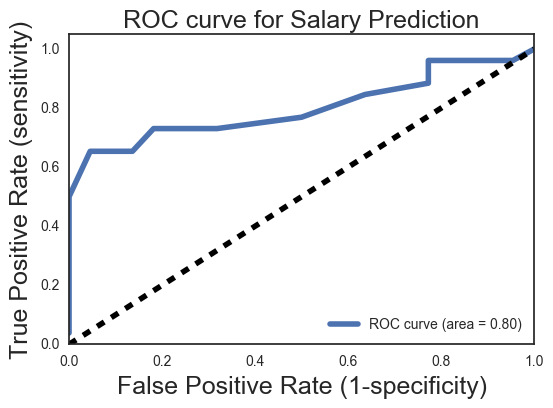

In [148]:
## YOUR CODE HERE
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline


Y_score = Logit.decision_function(X_test)
# For class malignant, find the area under the curve
FPR, TPR, THR = roc_curve(y_test, Y_score)
ROC_AUC = auc(FPR, TPR)

# Plot of a ROC curve for class 1 (has_cancer)
#plt.figure(figsize=[11,9])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1-specificity)', fontsize=18)
plt.ylabel('True Positive Rate (sensitivity)', fontsize=18)
plt.title('ROC curve for Salary Prediction', fontsize=18)
plt.legend(loc="lower right")
plt.show()

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy, AUC, precision and recall of the model. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.

#### Compare L1 and L2 regularization for this logistic regression model. What effect does this have on the coefficients learned?

In [172]:
Output_Table.head()

,Title_Cat,Location,Descriptions,Annual_Inc,Income_Cat,Income_Cat_Bin,Location_Short
3,Data Scientist,"New York, NY","As our representative in front of client, you ...",100000.0,"(89165.5, 312000]",1,NY
32,Data Scientist,"New York, NY","Extensive knowledge of applied statistics, ana...",79249.5,"[24960, 89165.5]",0,NY
95,Analyst,"New York, NY",Applying Machine Learning Algorithms and Libra...,90000.0,"(89165.5, 312000]",1,NY
151,Data Scientist,"New York, NY","Software Engineering, Python, Data Visualizati...",100000.0,"(89165.5, 312000]",1,NY
181,Analyst,"New York, NY",Several hires over the past two years have bee...,120000.0,"(89165.5, 312000]",1,NY


In [173]:
## YOUR CODE HERE
from sklearn.feature_extraction.text import CountVectorizer
v = CountVectorizer(
    binary=True,  # Create binary features
    stop_words='english', # Ignore common words such as 'the', 'and'
    max_features=50, # Only use the top 50 most common words
)
Wrd_df = v.fit_transform(Output_Table.Descriptions).todense()
Wrd_df = pd.DataFrame(Wrd_df, columns=v.get_feature_names())
Wrd_df.head(1)


,advanced,algorithms,analysis,analyst,analytics,analyze,assignment,based,big,business,...,senior,software,sql,statistical,statistics,strong,team,university,using,work
0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [174]:
## YOUR CODE HERE
Descrp_Table=X.reset_index()
Descrp_Table=Descrp_Table.drop('index',axis=1)
Descrp_Table=Descrp_Table.join(Wrd_df)
Descrp_Table.head(2)

,Location_Short_CA,Location_Short_FL,Location_Short_GA,Location_Short_IL,Location_Short_NY,Location_Short_OTHER,Location_Short_SFCA,Location_Short_TX,Location_Short_WA,Title_Cat_Analyst,...,senior,software,sql,statistical,statistics,strong,team,university,using,work
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0


In [175]:
X_train,X_test,y_train,y_test=train_test_split(Descrp_Table,y,test_size=0.3,random_state=3)

In [176]:
Logit=linear_model.LogisticRegression()
model=Logit.fit(X_train,y_train)
y_pred=model.predict(X_test)
print model.score(X_train,y_train)
print model.score(X_test,y_test)
cm = confusion_matrix(y_test, y_pred)

0.927272727273
0.8125


In [177]:
Logit1=linear_model.LogisticRegressionCV()
model1=Logit1.fit(X_train,y_train)
y_pred1=model1.predict(X_test)
print model1.score(X_train,y_train)
print model1.score(X_test,y_test)
cm1 = confusion_matrix(y_test, y_pred1)

0.909090909091
0.8125


In [178]:
Logit2=linear_model.LogisticRegressionCV(penalty='l1',solver='liblinear')
model2=Logit2.fit(X_train,y_train)
y_pred2=model2.predict(X_test)
print model2.score(X_train,y_train)
print model2.score(X_test,y_test)
cm2 = confusion_matrix(y_test, y_pred2)

0.954545454545
0.729166666667


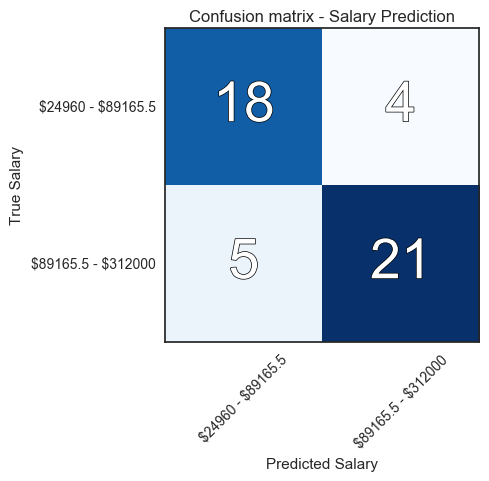

In [179]:
plot_confusion_matrix(cm1, 
                      title='Confusion matrix - Salary Prediction', 
                      labels=['\$24960 - \$89165.5','\$89165.5 - \$312000'], 
                      cmap=plt.cm.Blues)

With the addition of the Job Description key words varible the model accuracy has increased substantially. I have added regularisation due to the increase in variables however this has had a minimal impact  in the case of the L2 due to the default penalty within the logistic regression model, however the L1 model decreased the accuracy.

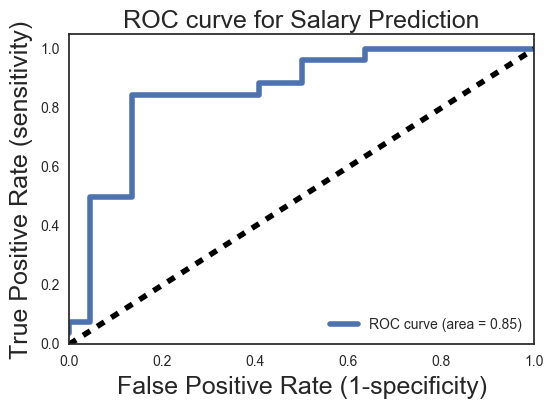

In [180]:
## YOUR CODE HERE
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline


Y_score = Logit.decision_function(X_test)

# For class malignant, find the area under the curve
FPR, TPR, THR = roc_curve(y_test, Y_score)
ROC_AUC = auc(FPR, TPR)

# Plot of a ROC curve for class 1 (has_cancer)
#plt.figure(figsize=[11,9])
plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1-specificity)', fontsize=18)
plt.ylabel('True Positive Rate (sensitivity)', fontsize=18)
plt.title('ROC curve for Salary Prediction', fontsize=18)
plt.legend(loc="lower right")
plt.show()

I will now look at splitting the outcome salary into more salary groups to see if I can predict the range of salaries more closely. Initially I will split the salaries into 4 groups.

In [181]:
y_quart=pd.qcut(Output_Table['Annual_Inc'],4)
y_quart.value_counts()

(130250, 312000]       40
[24960, 65244.25]      40
(89165.5, 130250]      39
(65244.25, 89165.5]    39
Name: Annual_Inc, dtype: int64

In [182]:
X_train,X_test,y_train,y_test=train_test_split(Descrp_Table,y_quart,test_size=0.3,random_state=10)

In [183]:
Logit=linear_model.LogisticRegression()
model=Logit.fit(X_train,y_train)
y_pred=model.predict(X_test)
print model.score(X_train,y_train)
print model.score(X_test,y_test)
cm = confusion_matrix(y_test, y_pred)

0.854545454545
0.604166666667


In [184]:
Logit1=linear_model.LogisticRegressionCV()
model1=Logit1.fit(X_train,y_train)
y_pred1=model1.predict(X_test)
print model1.score(X_train,y_train)
print model1.score(X_test,y_test)
cm1 = confusion_matrix(y_test, y_pred1)

0.881818181818
0.520833333333


In [185]:
Logit2=linear_model.LogisticRegressionCV(penalty='l1',solver='liblinear')
model2=Logit2.fit(X_train,y_train)
y_pred2=model2.predict(X_test)
print model2.score(X_train,y_train)
print model2.score(X_test,y_test)
cm2 = confusion_matrix(y_test, y_pred2)

0.881818181818
0.5625


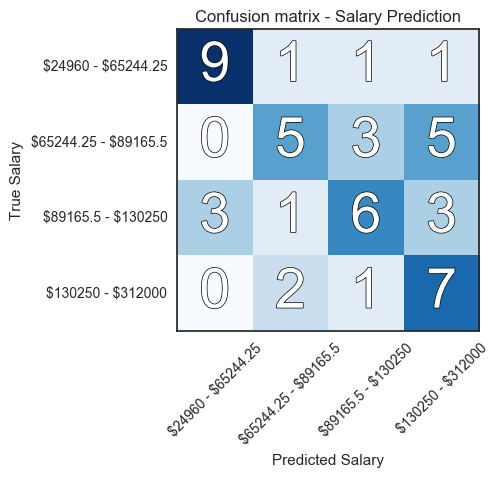

In [186]:
plot_confusion_matrix(cm2, 
                      title='Confusion matrix - Salary Prediction', 
                      labels=['\$24960 - \$65244.25','\$65244.25 - \$89165.5',
                              '\$89165.5 - \$130250','\$130250 - \$312000'], 
                      cmap=plt.cm.Blues)

There is a much larger descrepency between the test and training set once the additional salary ranges have been included, with a test set model score of over 50%, this is higher then the base of 25% however it is perhaps on the low side. I will look at the results if I just split the salary range into 3 groups.

In [216]:
y_quart=pd.qcut(Output_Table['Annual_Inc'],3)
y_quart.value_counts()

(73420, 112500]     53
[24960, 73420]      53
(112500, 312000]    52
Name: Annual_Inc, dtype: int64

In [188]:
X_train,X_test,y_train,y_test=train_test_split(Descrp_Table,y_quart,test_size=0.3,random_state=10)

In [189]:
Logit=linear_model.LogisticRegression()
model=Logit.fit(X_train,y_train)
y_pred=model.predict(X_test)
print model.score(X_train,y_train)
print model.score(X_test,y_test)
cm = confusion_matrix(y_test, y_pred)

0.836363636364
0.666666666667


In [190]:
Logit1=linear_model.LogisticRegressionCV()
model1=Logit1.fit(X_train,y_train)
y_pred1=model1.predict(X_test)
print model1.score(X_train,y_train)
print model1.score(X_test,y_test)
cm1 = confusion_matrix(y_test, y_pred1)

0.845454545455
0.604166666667


In [191]:
Logit2=linear_model.LogisticRegressionCV(penalty='l1',solver='liblinear')
model2=Logit2.fit(X_train,y_train)
y_pred2=model2.predict(X_test)
print model2.score(X_train,y_train)
print model2.score(X_test,y_test)
cm2 = confusion_matrix(y_test, y_pred2)

0.845454545455
0.583333333333


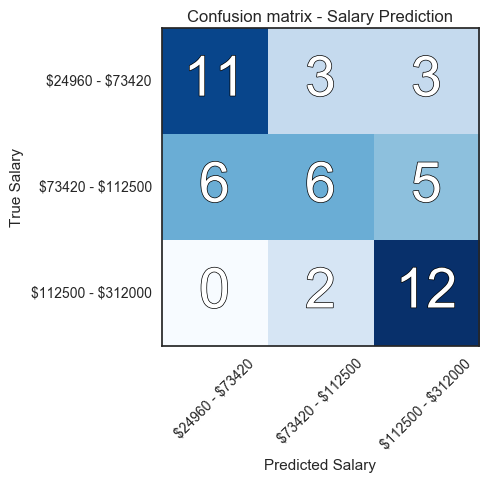

In [192]:
plot_confusion_matrix(cm1, 
                      title='Confusion matrix - Salary Prediction', 
                      labels=['\$24960 - \$73420','\$73420 - \$112500','\$112500 - \$312000'], 
                      cmap=plt.cm.Blues)

With just 3 salary ranges there is an increase in accuracy to 60% for the test set (baseline 33%), again there is a significant descrepancy between the traingin and test results however this is reduced compared to that of the 4 salary ranges. 

Below I will look a the coefficents to determine what varibles have the biggest impact on the salary prediction.

In [217]:
Coeffs1=pd.DataFrame({'Variable':list(X_train.columns),
              'Coeffs1':model1.coef_[0],
              'Coeffs2':model1.coef_[1],
              'Coeffs3':model1.coef_[2]})
Coeffs1.reindex(Coeffs1.Coeffs1.abs().sort_values(inplace=False,ascending=False).index).head()

,Coeffs1,Coeffs2,Coeffs3,Variable
14,1.941119,-0.356279,-0.876212,algorithms
38,1.916633,-0.213463,-1.505323,looking
30,-1.844187,0.154374,0.513736,health
34,1.617341,-0.295891,-1.407839,lead
12,1.509825,-0.406419,-1.041564,Title_Cat_Senior Data Scientist


In [210]:
Coeffs1.reindex(Coeffs1.Coeffs2.abs().sort_values(inplace=False,ascending=False).index).head()

,Coeffs1,Coeffs2,Coeffs3,Variable
44,-0.757988,-0.544890,2.110175,project
3,-1.024201,0.541292,-0.689531,Location_Short_IL
13,-1.194119,0.497309,-0.464937,advanced
54,-0.900042,0.486790,-0.599891,software
0,-0.111471,0.486441,-1.337199,Location_Short_CA


In [211]:
Coeffs1.reindex(Coeffs1.Coeffs3.abs().sort_values(inplace=False,ascending=False).index).head()

,Coeffs1,Coeffs2,Coeffs3,Variable
44,-0.757988,-0.544890,2.110175,project
38,1.916633,-0.213463,-1.505323,looking
34,1.617341,-0.295891,-1.407839,lead
18,-0.588583,-0.306694,1.339352,analyze
0,-0.111471,0.486441,-1.337199,Location_Short_CA


In [206]:
Coeffs=pd.DataFrame({'Variable':list(X_train.columns),
              'Coeffs1':model2.coef_[0],
              'Coeffs2':model2.coef_[1],
              'Coeffs3':model2.coef_[2]})
Coeffs.reindex(Coeffs.Coeffs1.abs().sort_values(inplace=False,ascending=False).index).head()

,Coeffs1,Coeffs2,Coeffs3,Variable
35,-3.499501,0.0,0.000000,leading
30,-3.397215,0.0,0.605518,health
53,-3.257933,0.0,0.000000,senior
38,3.174796,0.0,-2.027730,looking
34,3.133374,0.0,-2.432293,lead


In [207]:
Coeffs.reindex(Coeffs.Coeffs3.abs().sort_values(inplace=False,ascending=False).index).head()

,Coeffs1,Coeffs2,Coeffs3,Variable
44,-0.843641,0.0,3.119395,project
34,3.133374,0.0,-2.432293,lead
38,3.174796,0.0,-2.027730,looking
39,0.000000,0.0,-1.948989,machine
52,1.237227,0.0,-1.839390,scientists


Suprisingly the coefficients for location and title do not seem to be as large as those for key words in the descriptions.